In [14]:
import netcomp as nc

# use if making graphics for a presentation
plt.style.use(['classic','ggplot'])

figures_dir = '/Users/peterwills/google-drive/Research/Graph Distance Study/metrics_paper/figures'

We're looking at the [primary school temporal network dataset](http://www.sociopatterns.org/datasets/primary-school-temporal-network-data/).

This notebook is for the analysis used in the dynamic SBM paper. It considers the graph as a dynamic object, and looks at distances between timesteps.

# Get data from web

In [2]:
%%bash
cd data
curl -O http://www.sociopatterns.org/wp-content/uploads/2015/09/primaryschool.csv.gz
gunzip primaryschool.csv.gz

# grab metadata too

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
curl: (52) Empty reply from server
gunzip: primaryschool.csv already exists -- skipping


# Load in data

We have a bunch of time-stamped edges in a csv. We need to turn these into a sequence of graphs so that we can look at the resistance distance between timesteps. Let's see how this does.

In [3]:
full_data = pd.read_csv('../primary_school/data/day1.csv',sep='\t',header=None)
full_data.columns = ['Time','i','j','Class i','Class j']

data = full_data[full_data['Time'] <= 62300] # select only the first day

In [4]:
metadata = pd.read_csv('data/metadata_primaryschool.txt',sep='\t',header=None)
metadata.columns = ['ID','Class','Gender']

In [5]:
n_bins = 150
graphs = []
amats = []
amats_clean = []
bins = pd.cut(data['Time'],bins=n_bins,labels=np.arange(n_bins))

for group,df in data.groupby(bins):
    G = nx.Graph()
    G.add_nodes_from(metadata['ID'])
    G.add_edges_from(zip(df['i'],df['j']))
    graphs.append(G)
    amats.append(nx.adjacency_matrix(G))
    G.remove_nodes_from(nx.isolates(G))
    amats_clean.append(nx.adjacency_matrix(G))

# Analysis

Let's take the renormalized resistance distance between each graph, along with the edit distance, and see what we can see.

In [13]:
%%time

r_dists = []
e_dists = []
d_dists = []
ns_dists = []
adj_dists = []
lap_dists = []
nlap_dists = []

for A_old,A in zip(amats[:-1],amats[1:]):
    r_dists.append(nc.resistance_distance(A,A_old,renormalized=True))
    e_dists.append(nc.edit_distance(A,A_old))
    d_dists.append(nc.deltacon0(A,A_old))
    ns_dists.append(nc.netsimile(A,A_old))
    adj_dists.append(nc.lambda_dist(A,A_old,kind='adjacency'))
    lap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian'))
    nlap_dists.append(nc.lambda_dist(A,A_old,kind='laplacian_norm'))

CPU times: user 1min 39s, sys: 1.44 s, total: 1min 40s
Wall time: 1min 42s


In [16]:
# normalize by sample mean
r_dists = r_dists/np.mean(r_dists)
e_dists = e_dists/np.mean(e_dists)
d_dists = d_dists/np.mean(d_dists)
ns_dists = ns_dists/np.mean(ns_dists)
adj_dists = adj_dists/np.mean(adj_dists)
lap_dists = lap_dists/np.mean(lap_dists)
nlap_dists = nlap_dists/np.mean(nlap_dists)

In [17]:
# Assume start at 9 AM, end at 5 PM, subdivide time bins accordingly
times = [pd.to_datetime('10/1/2009 {}:{:.02f}'.format(int(time//1),60*(time%1))) 
         for time in np.linspace(9,17,num=n_bins)]

# our anomalies
significant_times = [pd.to_datetime('10/1/2009 ' + time_str) for time_str in 
                     ['10:30','11:00','12:00','13:00','14:00','15:30','16:00']]
time_labels = ['Morning Recess Begins',
               'Morning Recess Ends','First Lunch Begins','Second Lunch Begins',
               'Second Lunch Ends','Afternoon Recess Begins','Afternoon Recess Ends']

# we'll only mark the start of each bin, so we don't need the last one
times = times[:-1]
# distances all freak out towards the end of the day, as the graph dissolves
cutoff = -8

In [18]:
xtick_times = [pd.to_datetime('10/1/2009 {}:{:.02f}'.format(int(time//1),60*(time%1))) 
               for time in np.linspace(9,16,num=8)]
xtick_labels = ['{} AM'.format(i) for i in range(9,13)] + ['{} PM'.format(i) for i in range(1,5)]

# iterable of colors to use for anomaly indicators
color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d6272b','#9467bd','#8c564b','#e377c2']
# these are matplotlib.patch.Patch properties
# see https://matplotlib.org/users/recipes.html
props = [dict(boxstyle='round',color=color) for color in color_list]

# Matrix Distances

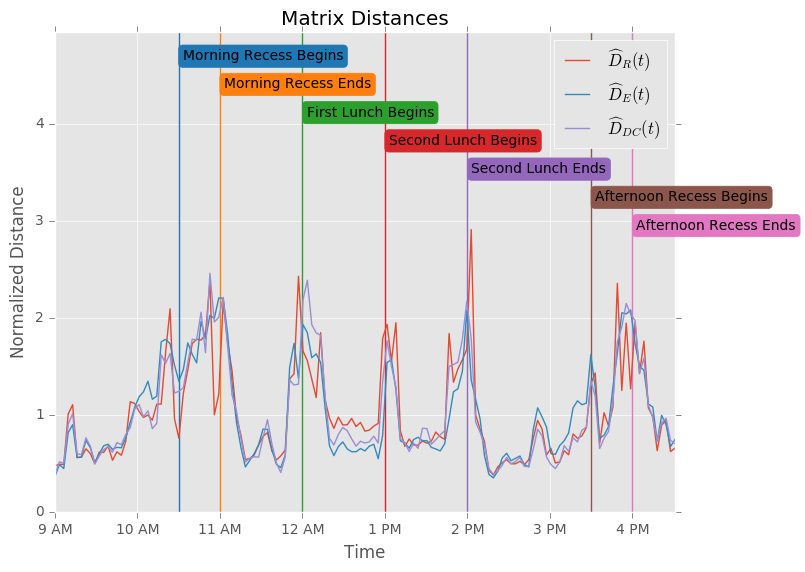

In [19]:
data_max = max(
    r_dists[:cutoff].max(),
    e_dists[:cutoff].max(),
    d_dists[:cutoff].max()
)

# Make locations for text
step = 0.1*data_max
text_heights = [data_max+step*i for i,_ in enumerate(significant_times)]
text_heights = text_heights[::-1]
text_times = [time+pd.Timedelta(minutes=3) for time in significant_times]
top = text_heights[0] + step

# make horizontal & vertical lines
[plt.axvline(dtime,color=color) for dtime,color in zip(significant_times,color_list)]
[plt.text(x,y,label,bbox=prop) for x,y,label,prop in 
 zip(text_times,text_heights,time_labels,props)]

# plot curves
plt.plot(times[:cutoff],r_dists[:cutoff],label='$\widehat{D}_R(t)$');
plt.plot(times[:cutoff],e_dists[:cutoff],label='$\widehat{D}_E(t)$');
plt.plot(times[:cutoff],d_dists[:cutoff],label='$\widehat{D}_{DC}(t)$');

# axes labels & title
plt.ylim([0,top]);
plt.xticks(xtick_times,xtick_labels);
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Matrix Distances');
plt.legend();

fig = plt.gcf();
fig.savefig(os.path.join(figures_dir,'primary_school_matrix.pdf'),
            dpi=300,bbox_inches='tight');

# Lambda Distances

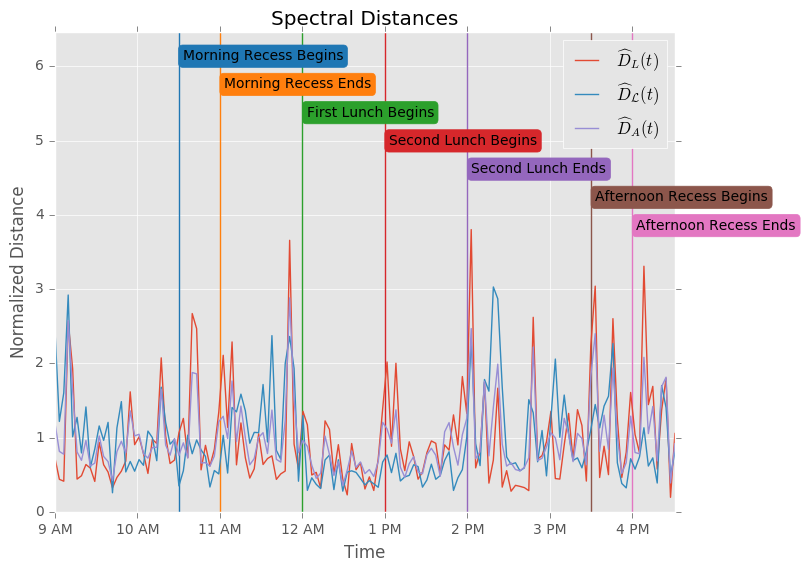

In [20]:
data_max = max(
    lap_dists[:cutoff].max(),
    adj_dists[:cutoff].max(),
    nlap_dists[:cutoff].max()
)

# Make locations for text
step = 0.1*data_max
text_heights = [data_max+step*i for i,_ in enumerate(significant_times)]
text_heights = text_heights[::-1]
text_times = [time+pd.Timedelta(minutes=3) for time in significant_times]
top = text_heights[0] + step

# make horizontal & vertical lines
[plt.axvline(dtime,color=color) for dtime,color in zip(significant_times,color_list)]
[plt.text(x,y,label,bbox=prop) for x,y,label,prop in 
 zip(text_times,text_heights,time_labels,props)]

# plot curves
plt.plot(times[:cutoff],lap_dists[:cutoff],label='$\widehat{D}_{L}(t)$');
plt.plot(times[:cutoff],nlap_dists[:cutoff],label='$\widehat{D}_{\mathcal{L}}(t)$');
plt.plot(times[:cutoff],adj_dists[:cutoff],label='$\widehat{D}_{A}(t)$');

# axes labels & title
plt.ylim([0,top]);
plt.xticks(xtick_times,xtick_labels);
plt.xlabel('Time');
plt.ylabel('Normalized Distance');
plt.title('Spectral Distances');
plt.legend();

fig = plt.gcf();
fig.savefig(os.path.join(figures_dir,'primary_school_lambda.pdf'),
            dpi=300,bbox_inches='tight');